# Метод главных компонент (PCA) и k-ближайших соседей (kNN)

### Выполнила: Иванова Елизавета Дмитриевна, НПМбд-01-19

In [1]:
import numpy as np
import matplotlib.pyplot as plt

Импортируем вспомогательные библиотеки:

In [2]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

## I. Датасет

1.  Скачиваем базу  данных  digits  при  помощи  функции load_digits из  пакета sklearn.datasets. Получаем массивы картинок в виде массива X, а также ответов labels:

In [3]:
digits = load_digits()
X = digits['data']
label = digits['target']

2.  При  помощи  функции  matplotlib.pyplot.imshow  рисуем  несколько  примеров картинок из X. Чтобы картинки шли в виде массива, а не друг под другом, используем функцию subplots:

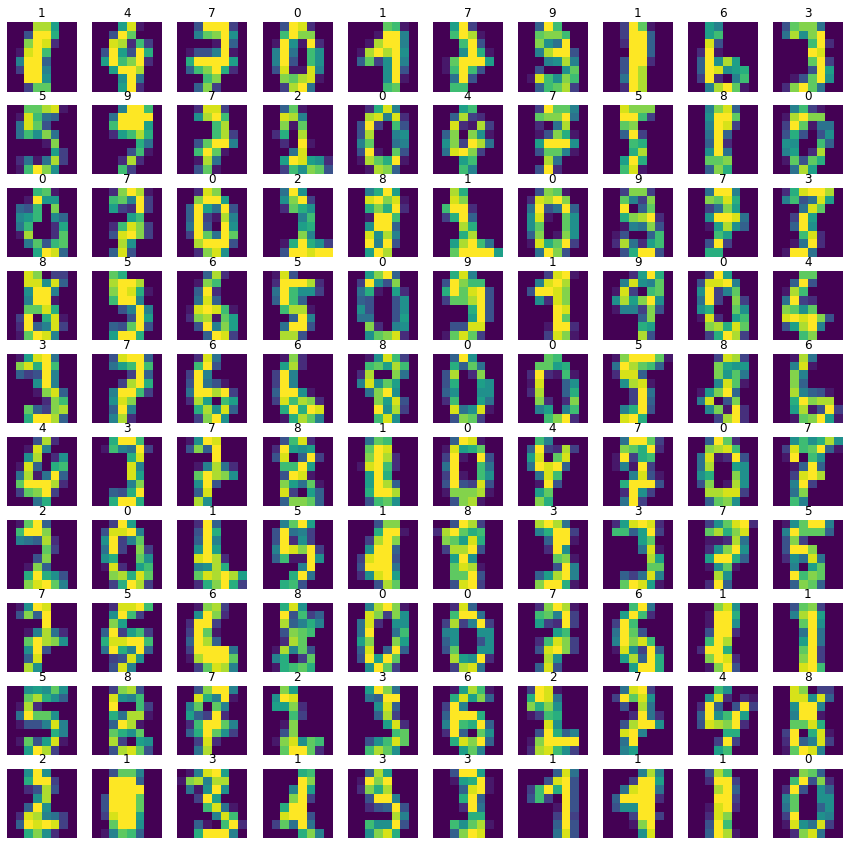

In [4]:
fig, ax = plt.subplots(10, 10, figsize=(15, 15))

for i in range(10):
    for j in range(10):
        k = np.random.randint(0, 1797)
        ax[i, j].imshow(X[k,:].reshape(8,8))
        ax[i, j].set_title(label[k])
        ax[i, j].axis('off')

## II. Алгоритм PCA

Метод главных компонент состоит из следующих 4-х шагов:  
1. Центрирование данных: $ X_c = X – \overline{X} $, где $ \overline{X} $ – среднее для каждого параметра 
2. Вычисление матрицы ковариации: $ C = X_c^TX_C $ 
3. Вычисление собственных векторов $ F $ и значений $ \lambda $ матрицы ковариации $ C $ 
4. Преобразование данных в координаты в базисе главных компонент: $ Y = X_cF $ 

In [5]:
class my_PCA(): 
    
    def __init__(self, n_components=None): 
        
        '''
        сохраняем число компонент n_components 
        
        ''' 
        self.n_components = n_components
    
    def fit(self, X):
        
        '''
        1. Центрирование данных 
        2. Вычисление матрицы ковариации 
        3. Вычисление собственных векторов и значений матрицы ковариации
        
        ''' 
        Xc = X
        Xc -= X.mean(axis=0)
        
        C = Xc.T.dot(Xc)

        lambda_, F = np.linalg.eigh(C)
        lambda_ = lambda_[::-1]
        F = F[:, ::-1]
        
        return Xc, F, lambda_
        
    
    def transform(self, X, F): 
        
        '''
        4. Преобразование данных в координаты в базисе главных компонент
        
        '''
        
        return X.dot(F)
    
    def fit_transform(self, X): 
        
        Xc, F, lambda_ = self.fit(X)
        Y = self.transform(Xc, F)
        
        if self.n_components != None:
            Y = Y[:, :(self.n_components)]
        
        return Y

Изобразим на графике точки датасета в первых двух координатах главных компонент:

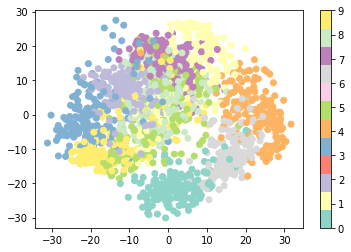

In [6]:
Y = my_PCA(2).fit_transform(X)

plt.scatter(Y[:, 0], Y[:, 1], c=label, cmap='Set3')
plt.colorbar()

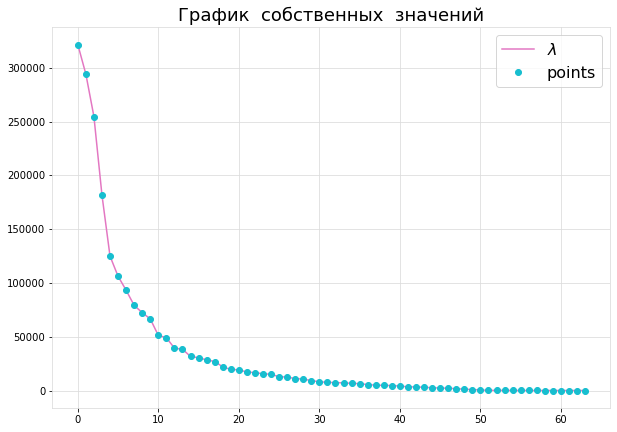

In [7]:
Xc, F, lambda_  = my_PCA(2).fit(X)

fig, ax = plt.subplots(figsize=(10, 7))
ax.set_title('График  собственных  значений', fontsize = 18)

ax.plot(lambda_, label='$ \lambda $', color = 'C6')
ax.plot(lambda_, 'o', label='points', color = 'C9')
plt.legend(fontsize = 16)

ax.grid(color = 'gainsboro')
ax.spines['right'].set_color('gainsboro')
ax.spines['top'].set_color('gainsboro')
ax.spines['left'].set_color('gainsboro')
ax.spines['bottom'].set_color('gainsboro')

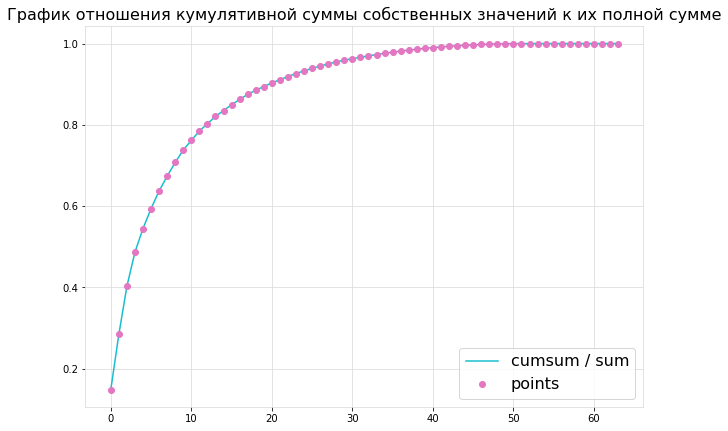

In [8]:
fig, ax = plt.subplots(figsize=(10, 7))
ax.set_title('График отношения кумулятивной суммы собственных значений к их полной сумме', fontsize = 16)

ax.plot(np.cumsum(lambda_) / np.sum(lambda_), label='cumsum / sum', color = 'C9')
ax.plot(np.cumsum(lambda_) / np.sum(lambda_), 'o', label='points', color = 'C6')
plt.legend(fontsize = 16)

ax.grid(color = 'gainsboro')
ax.spines['right'].set_color('gainsboro')
ax.spines['top'].set_color('gainsboro')
ax.spines['left'].set_color('gainsboro')
ax.spines['bottom'].set_color('gainsboro')

## III. Алгоритм kNN

Пусть  $ X_{train} $ – некоторая  обучающая  выборка  данных  с известными  классами  принадлежности  объектов $ y_{train} $.  
Предположим,  есть  некоторый объект $ x_* $  с  неизвестным  классом,  который  мы  хотели  бы  предсказать.  
Посчитаем расстояния от $ x_* $  до каждого из объектов $ X_{train} $ и найдём $ k $ ближайших (т.е. с наименьшим  расстоянием)  из  этого  набора.  
Мы знаем к какому классу принадлежат эти $ k $ соседей $ \implies $ мы  можем предположить, что и наш объект $ x_* $ будет принадлежать к тому классу, из которого наибольшее количество соседей.  

In [9]:
class my_kNN(): 
                    
    def __init__(self, n_neighbours=5):  # 5 соседей по умолчанию
        
        '''
        Сохранем параметр n_neighbours во внутреннюю переменную self.n_neighbours
        
        '''
        self.n_neighbours = n_neighbours
        
    def fit(self, X_train, y_train):
        
        '''
        Сохранем обучающую выборку данных X_train С известными  классами  принадлежности  объектов y_train во внутренние 
        переменные self.X_train и self.y_train соответственно
        
        '''
        self.X_train, self.y_train = X_train, y_train
    
    def predict(self, X):
        
        '''
        Предсказываем возможный класс, к которому принадлежит объект х_звёздочка
        
        '''
        class_of_x_zvezdochka = list()
        
        for x_zvezdochka in X:
            
            # набор расстояний от неизвестного объекта х_звёздочка до известных обучающих объектов X_train
            distances = list()
            
            # поиск расстояния от неизвестного объекта х_звёздочка до каждого элемента X_train
            for i in self.X_train:
                
                distance = np.linalg.norm(np.array(x_zvezdochka) - np.array(i))
                distances.append(distance)
                
            # индексы первых k минимальных расстояний (5 соседей в нашем случае)
            min_distances = np.argsort(distances)[:self.n_neighbours]
            
            # набор возможных классов для х_звёздочки
            possible_class = list()
            
            # индексы соседей х_звёздочки
            for i in min_distances:
                
                possible_class.append(self.y_train[i])
                
            # класс, из которого наибольшее количество соседей х_звёздочки            
            c = 0
            class_ = possible_class[0]
            
            for i in possible_class:
                
                count = possible_class.count(i)
                
                if count > c:
                    
                    c = count
                    class_ = i
            
            class_of_x_zvezdochka.append(class_)
            
            
        return class_of_x_zvezdochka

* Разбиваем данные X и label на обучающую и тестовую выборку, используя функцию train_test_split из модуля sklearn.model_selection. 
* Создаём классификатор my_kNN с числом соседей равным 5. Обучаем классификатор на обучающих данных. 
* Считаем точность на тестовой выборке, используя функцию accuracy_scoreиз модуля sklearn.metrics. Точность оказалась значительно больше 10%, значит алгоритм не работет как случайный, всё супер!

In [10]:
import timeit
start = timeit.default_timer()


X_train, X_test, y_train, y_test = train_test_split(X, label, train_size=1500, test_size=297, random_state=42) 
                                                                # number of samples = 1797

for i in range (1, 31):
    
    a = my_kNN(i)
    
    a.fit(X_train, y_train)
    class_of_x_zvezdochka = a.predict(X_test)
    
    print(f'Точность при k = {i}:', format(accuracy_score(y_test, class_of_x_zvezdochka) * 100, '.3f'))
    

stop = timeit.default_timer()
running_time = stop - start
print("\nВремя работы программы: " + str(running_time) + " секунд(-ы)")

Точность при k = 1: 97.643
Точность при k = 2: 97.643
Точность при k = 3: 98.316
Точность при k = 4: 97.980
Точность при k = 5: 98.653
Точность при k = 6: 98.653
Точность при k = 7: 98.653
Точность при k = 8: 98.653
Точность при k = 9: 98.653
Точность при k = 10: 97.980
Точность при k = 11: 98.653
Точность при k = 12: 98.316
Точность при k = 13: 98.316
Точность при k = 14: 98.316
Точность при k = 15: 98.316
Точность при k = 16: 98.316
Точность при k = 17: 98.653
Точность при k = 18: 98.653
Точность при k = 19: 98.316
Точность при k = 20: 97.980
Точность при k = 21: 97.643
Точность при k = 22: 97.643
Точность при k = 23: 97.643
Точность при k = 24: 97.643
Точность при k = 25: 97.643
Точность при k = 26: 97.980
Точность при k = 27: 97.980
Точность при k = 28: 97.980
Точность при k = 29: 97.980
Точность при k = 30: 97.980

Время работы программы: 146.384108 секунд(-ы)


* Уменьшаем размерность данных с помощью метода главных компонент.
* Применяем  алгоритм  kNN  к  преобразованным  данным. 
* Пробуем  разное  количество  соседей  (от  1  до  30)  и  разное  количество  компонент (начиная с одной и заканчивая всеми 64). 

In [11]:
start = timeit.default_timer()

components = []
for i in range(1, 65):
    components.append(i)

k = []
for i in range(1, 31):
    k.append(f'k = {i}')

accuracy_lst = []

for i in range(1, 65):
    
    Y = my_PCA(i).fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(Y, label, test_size=1500, train_size=297, random_state=42)
                                                                    # number of samples = 1797
    
    for j in range (1, 31):

        a = my_kNN(j)

        a.fit(X_train, y_train)
        class_of_x_zvezdochka = a.predict(X_test)
        
        accuracy_lst.append(format(accuracy_score(y_test, class_of_x_zvezdochka) * 100, '.3f'))
        
accuracy = np.array(accuracy_lst).reshape(64,30)

stop = timeit.default_timer()
running_time = stop - start
print("\nВремя работы программы: " + str(running_time) + " секунд(-ы)")


Время работы программы: 9054.6782393 секунд(-ы)


Создаём DataFrame в Pandas и выводим таблицу для наглядности:

In [12]:
import pandas as pd
%matplotlib inline

dframe = pd.DataFrame(accuracy, columns = k, index = components)
dframe.index.names = ['component']

dframe.to_csv('pca_knn_new.csv')

pass_data = pd.read_csv('pca_knn_new.csv')

In [13]:
pass_data

,component,k = 1,k = 2,k = 3,k = 4,k = 5,k = 6,k = 7,k = 8,k = 9,...,k = 21,k = 22,k = 23,k = 24,k = 25,k = 26,k = 27,k = 28,k = 29,k = 30
0,1,26.667,26.667,28.467,29.533,30.200,31.133,32.200,32.000,31.800,...,34.800,35.600,35.400,36.133,36.267,35.800,35.533,35.400,35.533,35.533
1,2,57.400,57.400,58.000,59.400,60.733,62.133,62.067,62.867,62.933,...,64.133,64.000,62.733,63.333,63.333,62.933,63.467,63.067,63.000,62.733
2,3,69.533,69.533,72.667,73.733,74.333,74.467,74.333,73.733,74.333,...,72.533,72.467,72.200,72.267,72.467,72.733,72.867,72.933,72.467,72.467
3,4,81.133,81.133,83.867,83.467,84.067,83.800,83.333,83.267,83.400,...,81.133,81.000,81.333,81.267,81.133,80.933,81.000,80.200,80.933,80.267
4,5,85.467,85.467,87.600,88.467,89.133,89.067,87.933,87.600,87.733,...,86.067,85.800,85.133,85.133,85.067,85.067,84.667,84.533,84.333,83.467
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,60,96.200,96.200,95.333,95.600,95.000,95.133,94.000,94.200,93.267,...,90.533,89.867,89.600,89.133,88.800,88.867,88.067,88.067,87.667,87.133
60,61,96.267,96.267,95.400,95.600,95.067,95.133,94.067,94.267,93.267,...,90.533,89.867,89.600,89.067,88.733,88.800,88.067,88.067,87.667,87.200
61,62,96.267,96.267,95.400,95.600,95.067,95.133,94.067,94.200,93.267,...,90.533,89.867,89.600,89.067,88.733,88.800,88.067,88.067,87.667,87.133
62,63,96.267,96.267,95.400,95.600,95.000,95.133,94.000,94.200,93.267,...,90.533,89.867,89.600,89.067,88.733,88.800,88.067,88.067,87.667,87.200


In [14]:
pass_data.iloc[0:60, 1:16]

,k = 1,k = 2,k = 3,k = 4,k = 5,k = 6,k = 7,k = 8,k = 9,k = 10,k = 11,k = 12,k = 13,k = 14,k = 15
0,26.667,26.667,28.467,29.533,30.200,31.133,32.200,32.000,31.800,32.133,32.933,32.867,32.667,32.133,32.400
1,57.400,57.400,58.000,59.400,60.733,62.133,62.067,62.867,62.933,62.867,62.200,62.333,62.733,62.933,63.133
2,69.533,69.533,72.667,73.733,74.333,74.467,74.333,73.733,74.333,74.067,74.067,73.467,73.200,73.600,73.733
3,81.133,81.133,83.867,83.467,84.067,83.800,83.333,83.267,83.400,83.133,82.133,82.067,82.133,82.467,82.600
4,85.467,85.467,87.600,88.467,89.133,89.067,87.933,87.600,87.733,87.533,87.467,87.667,87.733,86.933,87.000
5,87.800,87.800,89.067,89.600,89.133,88.800,88.333,88.667,87.733,87.933,87.467,87.667,87.267,87.200,87.000
6,90.800,90.800,91.267,92.133,91.000,91.133,89.933,90.533,89.667,89.067,88.400,88.000,88.067,87.933,87.733
7,91.400,91.400,91.333,92.467,90.867,91.600,90.267,90.200,89.667,89.067,88.000,88.667,88.667,88.600,88.733
8,93.333,93.333,93.267,93.867,92.667,92.600,91.933,91.533,91.067,90.600,89.933,90.000,90.200,89.933,89.933
9,93.267,93.267,93.533,93.267,92.400,92.333,91.733,91.733,90.400,90.733,90.067,90.133,89.933,89.400,89.400


In [15]:
pass_data.iloc[60:65, 1:16]

,k = 1,k = 2,k = 3,k = 4,k = 5,k = 6,k = 7,k = 8,k = 9,k = 10,k = 11,k = 12,k = 13,k = 14,k = 15
60,96.267,96.267,95.4,95.6,95.067,95.133,94.067,94.267,93.267,92.8,92.667,92.067,92.067,92.133,91.600
61,96.267,96.267,95.4,95.6,95.067,95.133,94.067,94.200,93.267,92.8,92.667,92.067,92.067,92.133,91.600
62,96.267,96.267,95.4,95.6,95.000,95.133,94.000,94.200,93.267,92.8,92.733,92.067,92.067,92.133,91.600
63,96.267,96.267,95.4,95.6,95.067,95.133,94.067,94.200,93.267,92.8,92.733,92.067,92.067,92.133,91.533


In [16]:
pass_data.iloc[0:60, 16:31]

,k = 16,k = 17,k = 18,k = 19,k = 20,k = 21,k = 22,k = 23,k = 24,k = 25,k = 26,k = 27,k = 28,k = 29,k = 30
0,32.933,33.800,34.133,35.133,34.867,34.800,35.600,35.400,36.133,36.267,35.800,35.533,35.400,35.533,35.533
1,63.533,63.867,64.400,64.133,64.667,64.133,64.000,62.733,63.333,63.333,62.933,63.467,63.067,63.000,62.733
2,73.533,72.867,72.200,72.533,72.400,72.533,72.467,72.200,72.267,72.467,72.733,72.867,72.933,72.467,72.467
3,82.200,82.133,81.800,81.067,81.000,81.133,81.000,81.333,81.267,81.133,80.933,81.000,80.200,80.933,80.267
4,86.467,86.533,86.200,86.133,86.133,86.067,85.800,85.133,85.133,85.067,85.067,84.667,84.533,84.333,83.467
5,86.667,87.200,86.667,86.733,86.267,86.467,86.467,86.267,85.400,85.067,84.800,84.533,84.600,84.133,83.467
6,87.400,87.200,86.733,86.800,86.800,86.467,86.000,85.600,85.000,84.667,84.600,84.333,83.867,83.133,82.933
7,88.600,88.133,87.600,87.333,87.133,86.600,86.200,85.533,85.400,84.800,84.733,84.333,84.400,84.733,84.933
8,89.400,89.133,88.267,88.200,87.800,87.800,87.800,87.667,87.867,87.600,87.733,87.467,86.867,86.800,86.667
9,89.133,88.733,88.600,88.533,88.333,87.867,88.067,87.867,87.933,87.800,87.800,87.267,87.267,87.267,87.467


In [17]:
pass_data.iloc[60:65, 16:31]

,k = 16,k = 17,k = 18,k = 19,k = 20,k = 21,k = 22,k = 23,k = 24,k = 25,k = 26,k = 27,k = 28,k = 29,k = 30
60,91.667,91.467,91.200,91.0,90.467,90.533,89.867,89.6,89.067,88.733,88.8,88.067,88.067,87.667,87.200
61,91.667,91.467,91.133,91.0,90.467,90.533,89.867,89.6,89.067,88.733,88.8,88.067,88.067,87.667,87.133
62,91.667,91.400,91.200,91.0,90.533,90.533,89.867,89.6,89.067,88.733,88.8,88.067,88.067,87.667,87.200
63,91.667,91.467,91.133,91.0,90.467,90.533,89.867,89.6,89.067,88.800,88.8,88.067,88.067,87.667,87.200


In [37]:
accuracy = np.array(accuracy_lst)

In [38]:
max(accuracy)

'96.467'

Наилучшая точность $ = 96.467 $. Она достигаетя при количестве соседей $ k = 1 $ и $ k = 2 $ и количестве компонент $ = 29 $ и  $ 31 $.